In [1]:
import numpy as np

def generate_synthetic_point_cloud(grid_size=100, extent=10, noise_level=0.02,
                                   n_obstacles=3, obstacle_size=5, obstacle_height=0.5):
    """
    Creates a synthetic point cloud representing a mostly flat area with a few raised obstacles.
    """
    xs = np.linspace(-extent/2, extent/2, grid_size)
    ys = np.linspace(-extent/2, extent/2, grid_size)
    xv, yv = np.meshgrid(xs, ys)

    zv = np.random.normal(loc=0.0, scale=noise_level, size=(grid_size, grid_size))
    points = np.column_stack((xv.flatten(), yv.flatten(), zv.flatten()))

    for _ in range(n_obstacles):
        cx = np.random.uniform(-extent/2, extent/2)
        cy = np.random.uniform(-extent/2, extent/2)
        mask = (np.abs(points[:,0] - cx) < (obstacle_size/2)) & \
               (np.abs(points[:,1] - cy) < (obstacle_size/2))
        points[mask,2] += obstacle_height + np.random.normal(scale=noise_level, size=np.sum(mask))

    return points

def ransac_plane(points, threshold=0.05, max_iterations=200):
    """
    Fits a plane to the point cloud using RANSAC and returns the best plane parameters
    (normal vector and offset) along with the indices of inlier points.
    """
    best_inliers = []
    best_plane = None
    n_points = points.shape[0]

    for _ in range(max_iterations):
        # Randomly select 3 points and compute plane
        idx = np.random.choice(n_points, 3, replace=False)
        p1, p2, p3 = points[idx]
        normal = np.cross(p2 - p1, p3 - p1)
        norm = np.linalg.norm(normal)
        if norm == 0:
            continue
        normal = normal / norm
        d = -np.dot(normal, p1)

        distances = np.abs(np.dot(points, normal) + d)
        inliers = np.where(distances < threshold)[0]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_plane = (normal.copy(), d)

    return best_plane, np.array(best_inliers, dtype=int)

def evaluate_landing_zone(points, plane, inliers, grid_extent=10):
    """
    Computes metrics for the detected plane and decides if it's suitable for landing.
    """
    normal, d = plane
    inlier_points = points[inliers]

    slope_deg = np.degrees(np.arccos(abs(normal[2])))

    residuals = np.abs(np.dot(inlier_points, normal) + d)
    flatness = np.std(residuals)

    total_area = grid_extent**2
    area = total_area * len(inliers) / len(points)

    slope_threshold = 5.0
    flatness_threshold = 0.05
    area_threshold = 20.0

    decision = (slope_deg < slope_threshold and
                flatness < flatness_threshold and
                area > area_threshold)

    return {
        'slope_deg': slope_deg,
        'flatness': flatness,
        'area': area,
        'decision': decision
    }

points = generate_synthetic_point_cloud()
plane, inliers = ransac_plane(points)
metrics = evaluate_landing_zone(points, plane, inliers)
print(f"Slope (deg):            {metrics['slope_deg']:.3f}")

print(f"Flatness (STD dist):    {metrics['flatness']:.3f}")
print(f"Estimated area (m²):    {metrics['area']:.2f}")
print(f"Inlier count:           {len(inliers)}")
print(f"Landing decision:       {'LAND' if metrics['decision'] else 'ABORT'}")


Slope (deg):            0.162
Flatness (STD dist):    0.012
Estimated area (m²):    53.58
Inlier count:           5358
Landing decision:       LAND


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

def generate_synthetic_point_cloud(grid_size=100, extent=10, noise_level=0.02,
                                   n_obstacles=3, obstacle_size=5, obstacle_height=0.5):
    """
    Creates a synthetic point cloud representing a mostly flat area with a few raised obstacles.
    """
    xs = np.linspace(-extent/2, extent/2, grid_size)
    ys = np.linspace(-extent/2, extent/2, grid_size)
    xv, yv = np.meshgrid(xs, ys)

    zv = np.random.normal(loc=0.0, scale=noise_level, size=(grid_size, grid_size))
    points = np.column_stack((xv.flatten(), yv.flatten(), zv.flatten()))

    # Store obstacle locations for visualization
    obstacle_locations = []

    for _ in range(n_obstacles):
        cx = np.random.uniform(-extent/2, extent/2)
        cy = np.random.uniform(-extent/2, extent/2)
        mask = (np.abs(points[:,0] - cx) < (obstacle_size/2)) & \
               (np.abs(points[:,1] - cy) < (obstacle_size/2))
        points[mask,2] += obstacle_height + np.random.normal(scale=noise_level, size=np.sum(mask))
        obstacle_locations.append((cx, cy))

    return points, obstacle_locations

def ransac_plane(points, threshold=0.05, max_iterations=200):
    """
    Fits a plane to the point cloud using RANSAC and returns the best plane parameters
    (normal vector and offset) along with the indices of inlier points.
    """
    best_inliers = []
    best_plane = None
    n_points = points.shape[0]

    for _ in range(max_iterations):
        # Randomly select 3 points and compute plane
        idx = np.random.choice(n_points, 3, replace=False)
        p1, p2, p3 = points[idx]
        normal = np.cross(p2 - p1, p3 - p1)
        norm = np.linalg.norm(normal)
        if norm == 0:
            continue
        normal = normal / norm
        d = -np.dot(normal, p1)

        distances = np.abs(np.dot(points, normal) + d)
        inliers = np.where(distances < threshold)[0]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_plane = (normal.copy(), d)

    return best_plane, np.array(best_inliers, dtype=int)

def evaluate_landing_zone(points, plane, inliers, grid_extent=10):
    """
    Computes metrics for the detected plane and decides if it's suitable for landing.
    """
    normal, d = plane
    inlier_points = points[inliers]

    slope_deg = np.degrees(np.arccos(abs(normal[2])))

    residuals = np.abs(np.dot(inlier_points, normal) + d)
    flatness = np.std(residuals)

    total_area = grid_extent**2
    area = total_area * len(inliers) / len(points)

    slope_threshold = 5.0
    flatness_threshold = 0.05
    area_threshold = 20.0

    decision = (slope_deg < slope_threshold and
                flatness < flatness_threshold and
                area > area_threshold)

    return {
        'slope_deg': slope_deg,
        'flatness': flatness,
        'area': area,
        'decision': decision
    }

def visualize_point_cloud(points, inliers=None, plane=None, obstacle_locations=None):
    """
    Visualize the point cloud with optional plane visualization and identified landing zone.
    """
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot all points in light gray
    ax.scatter(points[:,0], points[:,1], points[:,2], c='lightgray', s=10, alpha=0.3, label='All Points')

    # If inliers are provided, highlight them
    if inliers is not None:
        inlier_points = points[inliers]
        ax.scatter(inlier_points[:,0], inlier_points[:,1], inlier_points[:,2],
                   c='green', s=20, alpha=0.8, label='Landing Zone (Inliers)')

    # If obstacle locations are provided, mark them
    if obstacle_locations is not None:
        for cx, cy in obstacle_locations:
            ax.scatter(cx, cy, 0.5, c='red', s=100, marker='x', label='_nolegend_')

    # If plane parameters are provided, visualize the plane within the extent of the point cloud
    if plane is not None and inliers is not None:
        normal, d = plane

        # Create a mesh grid for the plane
        x_min, x_max = np.min(inlier_points[:,0]), np.max(inlier_points[:,0])
        y_min, y_max = np.min(inlier_points[:,1]), np.max(inlier_points[:,1])

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))

        # Calculate z values for the plane
        z = (-normal[0] * xx - normal[1] * yy - d) / normal[2]

        # Plot the plane as a surface
        ax.plot_surface(xx, yy, z, alpha=0.2, color='blue', label='Fitted Plane')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('Drone Landing Zone Analysis')

    # Create a custom legend
    handles, labels = ax.get_legend_handles_labels()
    if plane is not None:
        # Add a proxy for the plane surface
        blue_proxy = plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.2)
        handles.append(blue_proxy)
        labels.append('Fitted Plane')

    # Add a proxy for the obstacle markers
    if obstacle_locations is not None:
        obstacle_proxy = plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='red',
                                    markersize=10, label='Obstacles')
        handles.append(obstacle_proxy)
        labels.append('Obstacles')

    ax.legend(handles=handles, labels=labels, loc='upper right')

    plt.tight_layout()
    return fig, ax


Slope (deg):            0.097
Flatness (STD dist):    0.013
Estimated area (m²):    81.88
Inlier count:           8188
Landing decision:       LAND


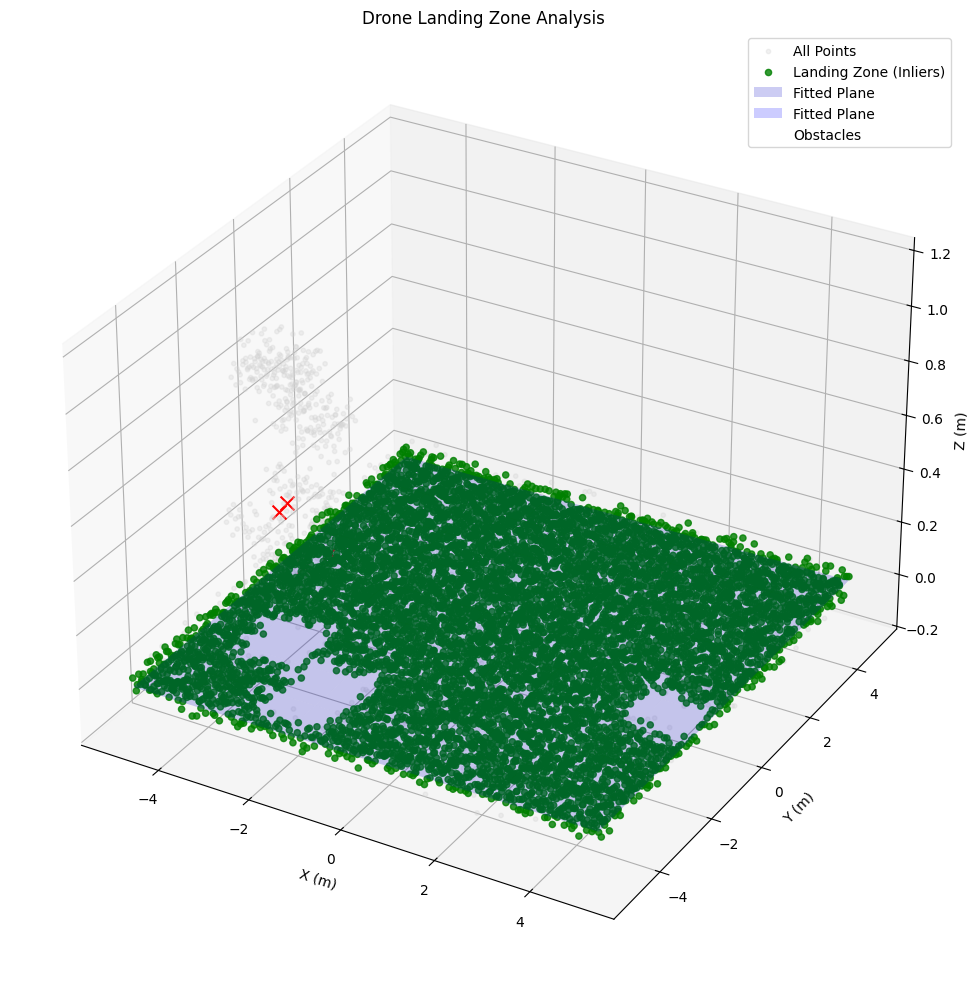

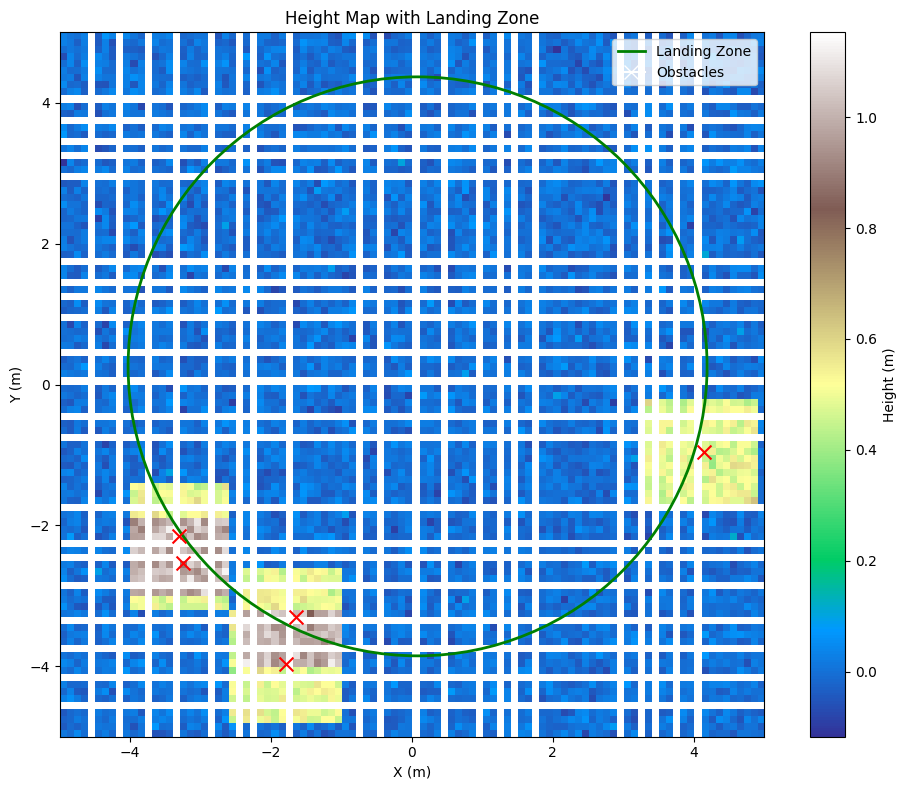


Realistic Terrain Analysis:
Slope (deg):            0.334
Flatness (STD dist):    0.014
Estimated area (m²):    37.44
Inlier count:           3744
Landing decision:       LAND


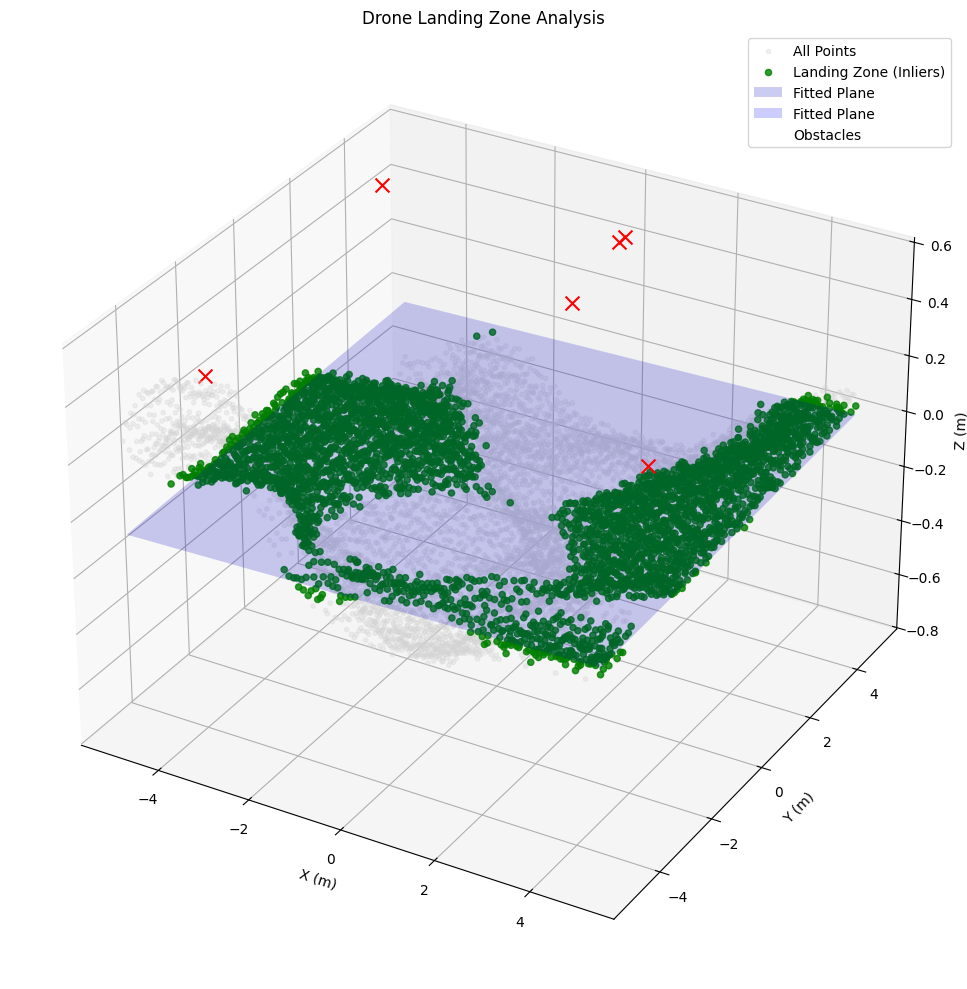

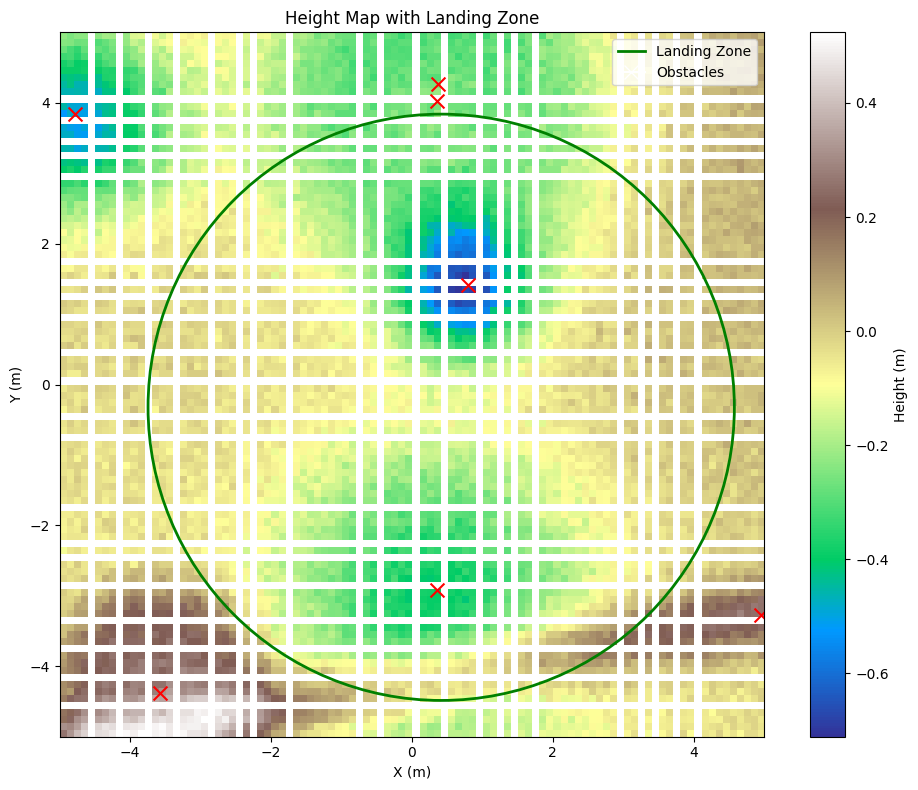

In [4]:
def visualize_height_map(points, inliers=None, obstacle_locations=None, grid_size=100, extent=10):
    """
    Create a 2D height map visualization of the point cloud
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a grid to store height values
    grid = np.zeros((grid_size, grid_size))
    grid_filled = np.zeros((grid_size, grid_size), dtype=bool)

    # Map points to grid cells
    for i, (x, y, z) in enumerate(points):
        grid_x = int((x + extent/2) / extent * (grid_size-1))
        grid_y = int((y + extent/2) / extent * (grid_size-1))

        if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
            grid[grid_y, grid_x] = z
            grid_filled[grid_y, grid_x] = True

    # Create a height map
    masked_grid = np.ma.masked_where(~grid_filled, grid)
    im = ax.imshow(masked_grid, cmap='terrain', extent=[-extent/2, extent/2, -extent/2, extent/2],
                   origin='lower', interpolation='nearest')

    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Height (m)')

    # If inliers are provided, mark the landing zone
    if inliers is not None:
        inlier_points = points[inliers]
        inlier_x = inlier_points[:, 0]
        inlier_y = inlier_points[:, 1]

        # Compute the centroid of inliers
        centroid_x = np.mean(inlier_x)
        centroid_y = np.mean(inlier_y)

        # Compute the approximate radius of the landing zone
        radius = np.sqrt(np.mean((inlier_x - centroid_x)**2 + (inlier_y - centroid_y)**2))

        # Draw a circle representing the landing zone
        landing_zone = plt.Circle((centroid_x, centroid_y), radius, color='green',
                                fill=False, linewidth=2, label='Landing Zone')
        ax.add_patch(landing_zone)

    # If obstacle locations are provided, mark them
    if obstacle_locations is not None:
        for cx, cy in obstacle_locations:
            ax.scatter(cx, cy, c='red', s=100, marker='x')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('Height Map with Landing Zone')

    # Add a legend
    if inliers is not None:
        obstacle_proxy = plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='red',
                                    markersize=10, label='Obstacles')
        landing_proxy = plt.Line2D([0], [0], color='green', linewidth=2, label='Landing Zone')
        ax.legend(handles=[landing_proxy, obstacle_proxy], loc='upper right')

    plt.tight_layout()
    return fig, ax

# Create a synthetic point cloud with more obstacles for better visualization
np.random.seed(42)  # For reproducibility
points, obstacle_locations = generate_synthetic_point_cloud(
    grid_size=100,
    extent=10,
    noise_level=0.03,
    n_obstacles=5,
    obstacle_size=1.5,
    obstacle_height=0.5
)

# Run RANSAC to detect a landing plane
plane, inliers = ransac_plane(points, threshold=0.05, max_iterations=200)

# Evaluate the landing zone
metrics = evaluate_landing_zone(points, plane, inliers)
print(f"Slope (deg):            {metrics['slope_deg']:.3f}")
print(f"Flatness (STD dist):    {metrics['flatness']:.3f}")
print(f"Estimated area (m²):    {metrics['area']:.2f}")
print(f"Inlier count:           {len(inliers)}")
print(f"Landing decision:       {'LAND' if metrics['decision'] else 'ABORT'}")

# Visualize the 3D point cloud
fig1, ax1 = visualize_point_cloud(points, inliers, plane, obstacle_locations)

# Visualize the height map
fig2, ax2 = visualize_height_map(points, inliers, obstacle_locations)

plt.show()

# Demonstrate terrain variations by generating more realistic terrain
def generate_realistic_terrain(grid_size=100, extent=10, base_noise=0.02,
                              feature_count=3, feature_size_range=(1, 3),
                              feature_height_range=(0.2, 0.8)):
    """
    Creates a more realistic terrain with various features like small hills, depressions, etc.
    """
    xs = np.linspace(-extent/2, extent/2, grid_size)
    ys = np.linspace(-extent/2, extent/2, grid_size)
    xv, yv = np.meshgrid(xs, ys)

    # Base terrain with some noise
    zv = np.random.normal(loc=0.0, scale=base_noise, size=(grid_size, grid_size))

    # Create a gradual slope
    slope_angle = np.random.uniform(0, 3)  # Random slope angle in degrees
    slope_direction = np.random.uniform(0, 2*np.pi)  # Random direction

    # Apply the slope
    slope_x = np.tan(np.radians(slope_angle)) * np.cos(slope_direction)
    slope_y = np.tan(np.radians(slope_angle)) * np.sin(slope_direction)

    zv += slope_x * xv + slope_y * yv

    # Add terrain features (hills, depressions, etc.)
    feature_types = ["hill", "depression", "ridge", "plateau"]
    feature_locations = []

    for _ in range(feature_count):
        cx = np.random.uniform(-extent/2, extent/2)
        cy = np.random.uniform(-extent/2, extent/2)
        feature_size = np.random.uniform(*feature_size_range)
        feature_height = np.random.uniform(*feature_height_range)
        feature_type = np.random.choice(feature_types)

        # Compute distance from feature center
        distance = np.sqrt((xv - cx)**2 + (yv - cy)**2)

        # Different feature shapes
        if feature_type == "hill":
            # Gaussian hill
            feature = feature_height * np.exp(-0.5 * (distance / (feature_size/2))**2)
        elif feature_type == "depression":
            # Depression (negative height)
            feature = -feature_height * np.exp(-0.5 * (distance / (feature_size/2))**2)
        elif feature_type == "ridge":
            # Ridge along a random direction
            ridge_angle = np.random.uniform(0, np.pi)
            ridge_dir_x = np.cos(ridge_angle)
            ridge_dir_y = np.sin(ridge_angle)
            along_ridge = np.abs(ridge_dir_y * (xv - cx) - ridge_dir_x * (yv - cy))
            feature = feature_height * np.exp(-0.5 * (along_ridge / (feature_size/3))**2)
        else:  # plateau
            # Plateau with soft edges
            plateau_radius = feature_size / 2
            soft_edge = plateau_radius * 0.3
            feature = feature_height * (1 - np.tanh((distance - plateau_radius) / soft_edge)) / 2

        zv += feature
        feature_locations.append((cx, cy, feature_type, feature_size))

    points = np.column_stack((xv.flatten(), yv.flatten(), zv.flatten()))
    return points, feature_locations

# Generate and visualize a more realistic terrain
realistic_points, feature_locations = generate_realistic_terrain(
    grid_size=100,
    extent=10,
    base_noise=0.02,
    feature_count=7,
    feature_size_range=(1, 4),
    feature_height_range=(0.2, 0.6)
)

# Run RANSAC to detect a landing plane on realistic terrain
realistic_plane, realistic_inliers = ransac_plane(realistic_points, threshold=0.05, max_iterations=300)

# Evaluate the landing zone
realistic_metrics = evaluate_landing_zone(realistic_points, realistic_plane, realistic_inliers)
print("\nRealistic Terrain Analysis:")
print(f"Slope (deg):            {realistic_metrics['slope_deg']:.3f}")
print(f"Flatness (STD dist):    {realistic_metrics['flatness']:.3f}")
print(f"Estimated area (m²):    {realistic_metrics['area']:.2f}")
print(f"Inlier count:           {len(realistic_inliers)}")
print(f"Landing decision:       {'LAND' if realistic_metrics['decision'] else 'ABORT'}")

# Extract feature locations only
feature_locs = [(x, y) for x, y, _, _ in feature_locations]

# Visualize the realistic terrain
fig3, ax3 = visualize_point_cloud(realistic_points, realistic_inliers, realistic_plane, feature_locs)
fig4, ax4 = visualize_height_map(realistic_points, realistic_inliers, feature_locs)

plt.show()